## REAL TIME FORECASTING (JANE STREET)

The competition dataset comprises a set of timeseries with 79 features and 9 responders, anonymized but representing real market data. The goal of the competition is to forecast one of these responders, i.e., responder_6, for up to six months in the future.

In line with the forecasting task, the competition will proceed in two phases:

A model training phase with a test set of historical data. This test set has about 4.5 million ro. 

.
A forecasting phase with a test set to be collected after submissions close. You should expect this test set to be about the same size as the test set in the first phase.

**train.parquet** - The training set, contains historical data and returns. For convenience, the training set has been partitioned into ten parts.
* 
date_id and time_id - Integer values that are ordinally sorted, providing a chronological structure to the data, although the actual time intervals between time_id values may vary

.* 
symbol_id - Identifies a unique financial instrumen
  
t* .
weight - The weighting used for calculating the scoring functi
  
o* n.
feature_{00...78} - Anonymized market d
  
a* ta.
responder_{0...8} - Anonymized responders clipped between -5 and 5. The responder_6 field is what you are trying to predict.

In [1]:
import os
import kaggle_evaluation.jane_street_inference_server
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import gc
import matplotlib.pyplot as plt 

import kaggle_evaluation.jane_street_inference_server
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score
from torch.cuda.amp import GradScaler, autocast


In [2]:
# file_path = "/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet"
# dt = pd.read_parquet(file_path)
# dt

In [3]:
data = []
for i in range(9):
    file_path = f"/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet"
    dt = pd.read_parquet(file_path)
    data.append(dt.sample(n=500000, random_state=42))

del dt
gc.collect()

df = pd.concat(data, ignore_index=True)
df.head()

del data
gc.collect()

0

In [4]:
df['symbol_id'].value_counts().sum()

4500000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500000 entries, 0 to 4499999
Data columns (total 92 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date_id      int16  
 1   time_id      int16  
 2   symbol_id    int8   
 3   weight       float32
 4   feature_00   float32
 5   feature_01   float32
 6   feature_02   float32
 7   feature_03   float32
 8   feature_04   float32
 9   feature_05   float32
 10  feature_06   float32
 11  feature_07   float32
 12  feature_08   float32
 13  feature_09   int8   
 14  feature_10   int8   
 15  feature_11   int16  
 16  feature_12   float32
 17  feature_13   float32
 18  feature_14   float32
 19  feature_15   float32
 20  feature_16   float32
 21  feature_17   float32
 22  feature_18   float32
 23  feature_19   float32
 24  feature_20   float32
 25  feature_21   float32
 26  feature_22   float32
 27  feature_23   float32
 28  feature_24   float32
 29  feature_25   float32
 30  feature_26   float32
 31  feature_27   float32
 32

In [6]:
features = df.filter(regex = '^feature_')
# features = features.astype('float16')
responders = df.filter(regex='^responder_')
responders = responders.astype('float16')
weights = df['weight'].astype('float16')
time_id = df[['time_id']].astype('int16')
symbol_id = df[['symbol_id']].astype('int16')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


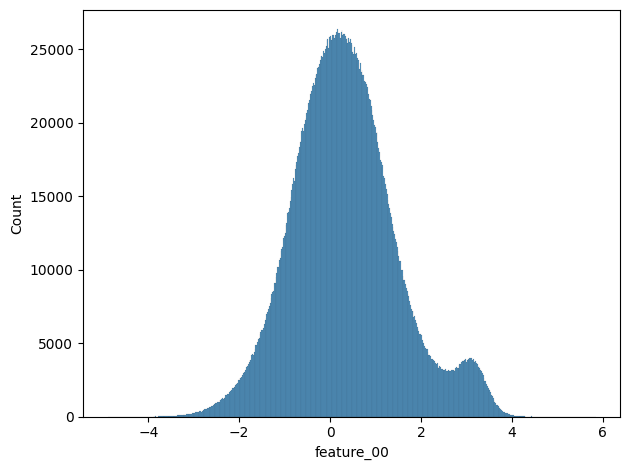

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


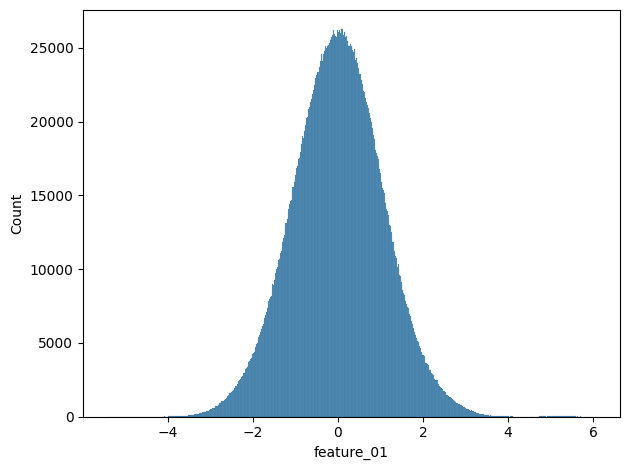

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


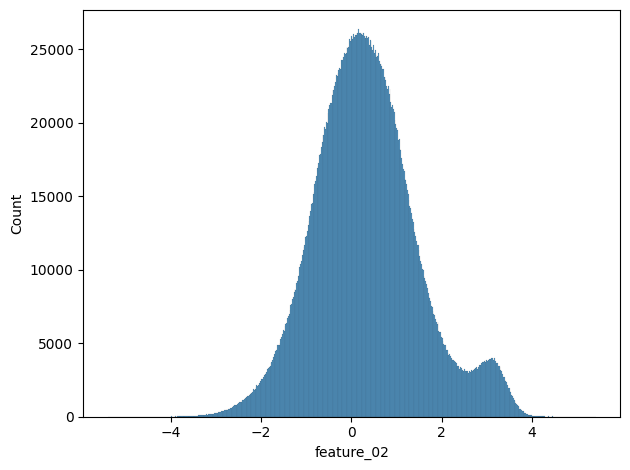

In [7]:
for ft in features.columns[:3]:
    sns.histplot(features[ft].astype(float))
    plt.tight_layout();
    plt.show();

In [8]:
# features.isnull().sum()
# replace the null values with the mean
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
features = features.fillna(features.mean())
features_scaled = scaler.fit_transform(features)
features = pd.DataFrame(features_scaled, columns=features.columns)
features

del features_scaled
gc.collect()

78373

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


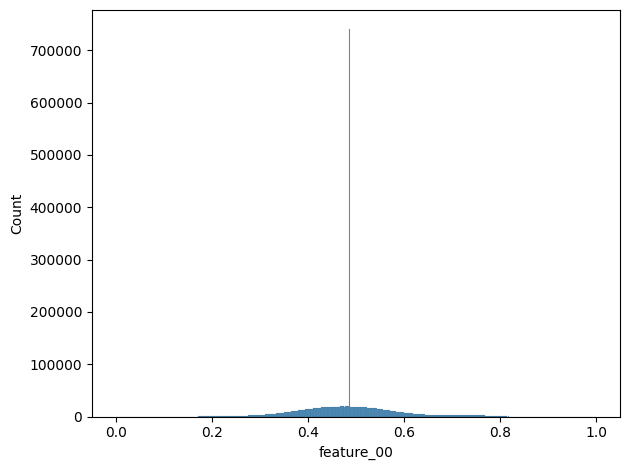

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


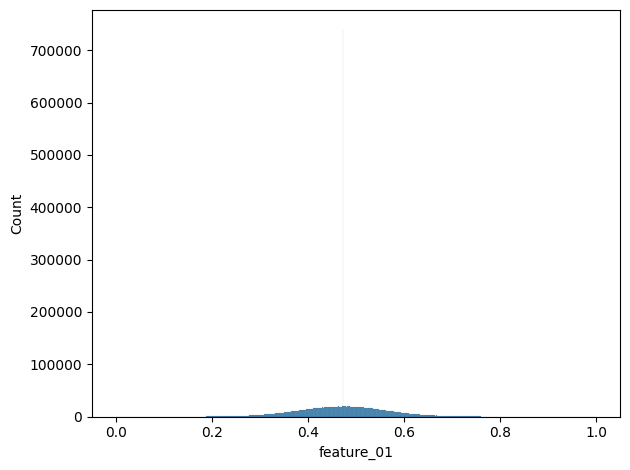

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


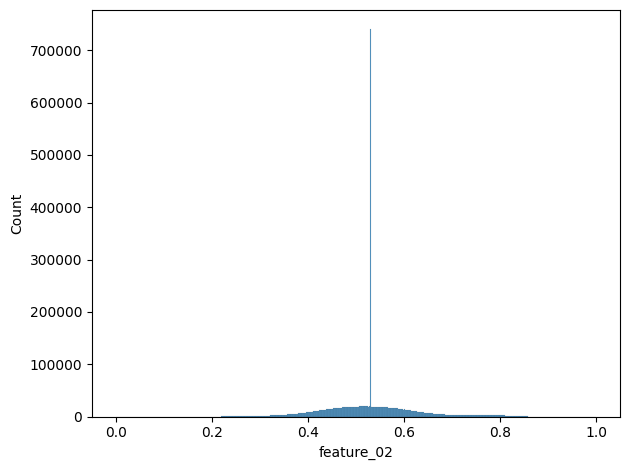

In [9]:
for ft in features.columns[:3]:
    sns.histplot(features[ft].astype(float))
    plt.tight_layout();
    plt.show();

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, weights_train, weights_val = train_test_split(
    features, responders['responder_6'], weights, test_size=0.2, random_state=42
)

In [11]:
print(f'X_train shape {X_train.shape}, y_train{y_train.shape}')
print(f'X_val shape {X_val.shape}, y_val{y_val.shape}')
print(f'weights_train shape {weights_train.shape}, weights_val{weights_val.shape}')


X_train shape (3600000, 79), y_train(3600000,)
X_val shape (900000, 79), y_val(900000,)
weights_train shape (3600000,), weights_val(900000,)


In [12]:
unique_symbol_ids = sorted(symbol_id['symbol_id'].unique())

## Model

In [13]:
symbol_id_embedding = False
class ModelJane(nn.Module):
    def __init__ (self, num_features, unique_symbol_ids, embedding_dim=16):
        super().__init__()
        input_dim = num_features + (embedding_dim if symbol_id_embedding else 0)
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        if symbol_id_embedding:
            self.embedding = nn.Embedding(len(unique_symbol_ids), embedding_dim)

    def forward(self, x, symbol_ids):
        if symbol_id_embedding:
            symbol_embeds = self.embedding(symbol_ids).squeeze(1)
            x = torch.cat([x, symbol_embeds], dim =1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)

        return self.fc4(x)
            

In [14]:
model = ModelJane(len(features.columns), unique_symbol_ids)
model

ModelJane(
  (fc1): Linear(in_features=79, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [15]:
weights_train

1005552    1.520508
2422375    1.277344
1308462    0.752441
2163361    0.293457
3069961    3.388672
             ...   
1136074    1.511719
1570006    0.306641
2234489    1.372070
4304572    1.913086
1692743    0.802246
Name: weight, Length: 3600000, dtype: float16

In [16]:

class CustomDataset(Dataset):
    def __init__(self, features, targets, weights=None):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)
        self.weights = torch.tensor(weights.values, dtype=torch.float32) if weights is not None else None

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.targets[idx]
        w = self.weights[idx] if self.weights is not None else 1.0
        return x, y, w


In [17]:
batch_size = 4096

# Prepare training and validation datasets
train_dataset = CustomDataset(X_train, y_train, weights_train)
val_dataset = CustomDataset(X_val, y_val, weights_val)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [18]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)

True
12.3


In [19]:
# Weighted R2 Scoring function
def weighted_r2_score(y_true, y_pred, weights):
    # Calculate the weighted residual sum of squares
    residual_sum_of_squares = torch.sum(weights * (y_true - y_pred) ** 2)
    
    # Calculate the weighted total sum of squares
    total_sum_of_squares = torch.sum(weights * y_true ** 2)
    
    # Calculate weighted R2 score
    r2_score = 1 - (residual_sum_of_squares / total_sum_of_squares)
    
    return r2_score.item()  # Return as a scalar value


In [20]:



# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_features = X_train.shape[1]
unique_symbol_ids = unique_symbol_ids  # Update with actual unique symbol IDs if used
model = ModelJane(num_features, unique_symbol_ids).to(device)

criterion = nn.MSELoss(reduction='none')  # Use reduction='none' for weighted loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Initialize best validation loss
best_val_loss = float('inf')

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch, w_batch in train_loader:
        X_batch, y_batch, w_batch = X_batch.to(device), y_batch.to(device), w_batch.to(device)

        # Forward pass
        predictions = model(X_batch, None).squeeze(1)  # Adjust based on model output
        loss = criterion(predictions, y_batch)
        weighted_loss = (loss * w_batch).mean()  # Weighted loss

        # Backward pass
        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()

        train_loss += weighted_loss.item()

    # print(f"Epoch {epoch + 1}/{epochs}, ")

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_r2_score = 0.0
    with torch.no_grad():
        for X_batch, y_batch, w_batch in val_loader:
            X_batch, y_batch, w_batch = X_batch.to(device), y_batch.to(device), w_batch.to(device)

            predictions = model(X_batch, None).squeeze(1)
            loss = criterion(predictions, y_batch)
            weighted_loss = (loss * w_batch).mean()

            val_loss += weighted_loss.item()

            # Compute the weighted R2 score for the current batch
            r2 = weighted_r2_score(y_batch, predictions, w_batch)
            val_r2_score += r2

    # Average validation loss and R2 score across all batches
    val_loss_avg = val_loss / len(val_loader)
    val_r2_score_avg = val_r2_score / len(val_loader)

    print(f"Epoch {epoch + 1}/{epochs},Train Loss: {train_loss / len(train_loader)}, Validation Loss: {val_loss_avg}, Validation R2 Score: {val_r2_score_avg}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model state_dict
        torch.save(model.state_dict(), 'best_model.pth')
        # print(f"Best model saved at Epoch {epoch + 1} with Validation Loss: {val_loss_avg}")


Epoch 1/30,Train Loss: 1.4265543112575805, Validation Loss: 1.4212313565340908, Validation R2 Score: 0.0026348753408952192
Epoch 2/30,Train Loss: 1.424433349749334, Validation Loss: 1.4202123468572443, Validation R2 Score: 0.0033680371262810446
Epoch 3/30,Train Loss: 1.4230326065566896, Validation Loss: 1.418182696537538, Validation R2 Score: 0.004784927584908226
Epoch 4/30,Train Loss: 1.421275549509962, Validation Loss: 1.4170386238531634, Validation R2 Score: 0.005554160746661099
Epoch 5/30,Train Loss: 1.41992128451394, Validation Loss: 1.414990146593614, Validation R2 Score: 0.0069928085262125185
Epoch 6/30,Train Loss: 1.4191601928726127, Validation Loss: 1.4142436455596576, Validation R2 Score: 0.007502610575069081
Epoch 7/30,Train Loss: 1.4189143900985197, Validation Loss: 1.4134844785386866, Validation R2 Score: 0.008025064251639626
Epoch 8/30,Train Loss: 1.4179915459625279, Validation Loss: 1.413526108048179, Validation R2 Score: 0.008025968074798584
Epoch 9/30,Train Loss: 1.417

In [21]:
model.load_state_dict(torch.load('best_model.pth', map_location=device, weights_only=True))
model.eval()

ModelJane(
  (fc1): Linear(in_features=79, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [22]:
def make_prediction(models, X, symbol_ids):
    """Generate predictions by averaging across all models."""
    y_preds = []
    with torch.no_grad():
        for model in models:
            # Convert inputs to torch tensors
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            symbol_ids_tensor = torch.tensor(symbol_ids, dtype=torch.int).to(device)
            # Predict and store results
            y_pred = model(X_tensor, symbol_ids_tensor).squeeze(1)
            y_preds.append(y_pred.cpu().numpy())
    return np.mean(y_preds, axis=0)  # Ensemble by averaging predictions


In [23]:
lags_ : pl.DataFrame | None = None


def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
    """Make a prediction."""
    # All the responders from the previous day are passed in at time_id == 0. We save them in a global variable for access at every time_id.
    # Use them as extra features, if you like.
    global lags_
    if lags is not None:
        lags_ = lags

    X_test = test.select(features.columns).to_numpy()
    col_means = features.mean().values 
    X_test = np.where(np.isnan(X_test), col_means, X_test)  # Replace NaNs with mean values
    X_test = scaler.transform(X_test)  # Normalize features
    X_test = np.nan_to_num(X_test, nan=0)  # Ensure no NaNs remain

    # Extract symbol IDs
    symbol_ids = test.select(["symbol_id"]).to_numpy()

    # Make predictions
    y_pred = make_prediction([model], X_test, symbol_ids)

    # Prepare the output DataFrame
    predictions = test.select('row_id').with_columns(
        pl.Series("responder_6", y_pred)
    )

    # Ensure output format is correct
    assert isinstance(predictions, pl.DataFrame)
    assert predictions.columns == ['row_id', 'responder_6']
    assert len(predictions) == len(test)

    return predictions

In [24]:
inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet',
            '/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet',
        )
    )

/kaggle/input/jane-street-real-time-market-data-forecasting/kaggle_evaluation/core/templates.py:128: RuntimeWarning: 2553 seconds elapsed before server startup.
                This exceeds the startup time limit of 900 seconds that the gateway will enforce
                during the rerun on the hidden test set. Start the server before performing any time consuming steps.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
